# Criminal Soccer
**Team:** Michael Gangl, Sebastian Grünewald, Patrick Leitner

## Topic
The goal of the project is to load and process various datasets from the soccer area and visualize the results. The project is to be run and analyzed under the
Big Data aspect. For this purpose, relational and NoSQL databases were used, as well as a MapReduce algorithm. Furthermore, the architecture is built in a way that all services and metadata are hosted and is therefore multiuser capable.

## Question
With our diagrams we want to analyze if there are correlations between the foul statistics of the players and the crime statistics of their countries of origin.
Additionally, some other interesting and relevant graphs about the datasets will be shown.

## Architecture
[GitHub](https://github.com/petz1209/fh_bdi_soccer_project)

Azure: fhtw-bdinf-wi21b080-azuredatabase-mysql.mysql.database.azure.com
MySQL Database: `criminalsoccer`
MySQL Table: `nationalities`

MongoDB: mongodb://pt-n20.p4001.w3.cs.technikum-wien.at:4001
MongoDB Database: `criminalSoccer`
MongoDB Collections: `raw_players`, `players`, `countries`

![Architecture Diagram](imgs/Architecture_Diagram.jpg)

# Big Data Perspective
Analysis visible in file: `big data perspective.pdf`

## Data Collection
The following scripts load the data from various sources and stores it into MongoDB
### Datasets
[Kaggle UEFA (.csv-files)](https://www.kaggle.com/datasets/azminetoushikwasi/ucl-202122-uefa-champions-league): This dataset contains all the player stats of UEFA Champions League season 2021-22.

[TransferMarkt-API](https://www.transfermarkt.com/schnellsuche/ergebnis/schnellsuche): To complete the player stats, we used the Transfermarkt API to search for players by their name.

[Wikipedia National Crime Stats](https://en.wikipedia.org/wiki/List_of_countries_by_intentional_homicide_rate): Wikipedia provides a table with crime rates per 100.000 inhabitants.

### Technical Notice
**Make sure Docker is up and running!**
Due to historical problems with the hosted MongoDB instance from the FH, we implemented a backup strategy with Docker.

### Steps
1. Prepare local backup strategy for mongo with a docker container due to problems with the hosted mongo instance.
2. Download UEFA Dataset from kaggle and store the data in MongoDB.
3. Iterate over player names and scrape additional information from Transfermarkt.com API.
4. Transform the data with proper datatypes and cleanup combined dataset.
5. Scrape Wikipedia to get crime statistics per country and store it in MongoDB.

In [14]:
import pandas as pd
import zipfile
import os
import requests

# Importing necessary packages for mongodb connectivity
try:
    from pymongo import MongoClient
    from pymongo.errors import ServerSelectionTimeoutError
except ImportError:
    !pip install pymongo[srv]
    from pymongo import MongoClient
    from pymongo.errors import ServerSelectionTimeoutError

# Importing config from config.py
from conifg import MONGO_HOST_REMOTE, MONGO_DB_REMOTE, MONGO_HOST_LOCAL, MONGO_DB_LOCAL

# Defining constants for kaggle files
UEFA_ZIP = "kaggle_players_zip.zip"
UEFA_UNZIPPED = "kaggle_files"
UEFA_FILES = ["key_stats.csv", "disciplinary.csv", "distributon.csv", "defending.csv"] # only some .csv-files are interesting for our purposes
UEFA_RAW_DATA = "raw_players"

# Defining constants for MongoDB connection
conn_str = MONGO_HOST_REMOTE
mongoDB = MONGO_DB_REMOTE

class MongoContext:
    """mongodb client context manager"""
    def __init__(self):
        self.conn_str = MONGO_HOST_REMOTE
        self.mongoDB = MONGO_DB_REMOTE
    def __enter__(self):
        try:
            # print(f"conn_str: {conn_str}  mongoDB: {self.mongoDB}")
            # Connection to Mongo Server from FH-Technikum
            self.client = MongoClient(conn_str)
            self.client.server_info()
            #print("Connection successful to remote mongo host")
            return self.client
        # If connection is not possible, setting a local docker instance
        except ServerSelectionTimeoutError as err:
            print("Remote Error: " + str(err))
            os.system("docker pull mongo")
            os.system("docker run -d -p 27017:27017 mongo:latest")
            self.con_str = MONGO_HOST_LOCAL
            self.mongoDB = MONGO_DB_LOCAL
            try:
                # Trying to connect to the local docker Mongo database
                self.client = MongoClient(conn_str)
                self.client.server_info()
                #print("Connection successful to local mongo host")
                return self.client
            except ServerSelectionTimeoutError as errLocal:
                print("Local Error: " + str(errLocal))

    def __exit__(self, exception_type, exception_value, exception_traceback):
        self.client.close()
        del self.client

def unpack_zip(src, dest):
    """takes files in zip folder from src and extracts them to dest"""
    with zipfile.ZipFile(src, 'r') as zip_ref:
        zip_ref.extractall(dest)

def csv_to_mongo(folder, files, map_key):
    """Fetching data from interesting files in csv folder"""
    # kill existing collection if it exists:
    with MongoContext() as client:
        db = client[mongoDB]
        collection = db[UEFA_RAW_DATA]
        collection.drop()

        for idx, file in enumerate(files):
            df = pd.read_csv(f"{folder}/{file}")
            data = df.to_dict(orient='records')
            if idx == 0:
                # Insert data into mongo
                collection.insert_many(data)
            else:
                for row in data:
                    # Insert data into mongo
                    query = {map_key:  row[map_key]}
                    new_values = {"$set": row}
                    collection.update_one(query, new_values)

def read_from_mongo():
    """reading from mongo database and printing the collection"""
    with MongoContext() as client:
        db = client[mongoDB]
        collection = db[UEFA_RAW_DATA]

        data = collection.find()
        for x in data:
            print("==========================================================================")
            print(x)

def collect_from_kaggle():

    # guard, in case data is already in database.
    with MongoContext() as client:
        db = client[mongoDB]
        if UEFA_RAW_DATA in db.list_collection_names():
            print(f"{UEFA_RAW_DATA} is already in database")
            return False

    unpack_zip(UEFA_ZIP, UEFA_UNZIPPED)
    csv_to_mongo(UEFA_UNZIPPED, UEFA_FILES, "player_name")
    read_from_mongo()

collect_from_kaggle()

{'_id': ObjectId('644b8ed8f7fb1e526a4dd719'), 'player_name': 'Courtois', 'club': 'Real Madrid', 'position': 'Goalkeeper', 'minutes_played': 1230, 'match_played': 13, 'goals': 0, 'assists': 0, 'distance_covered': '64.2', 'cross_accuracy': 0, 'cross_attempted': 0, 'cross_complted': 0, 'freekicks_taken': 27, 'pass_accuracy': 76.7, 'pass_attempted': 483, 'pass_completed': 365, 'serial': 447}
{'_id': ObjectId('644b8ed8f7fb1e526a4dd71a'), 'player_name': 'Vinícius Júnior', 'club': 'Real Madrid', 'position': 'Forward', 'minutes_played': 1199, 'match_played': 13, 'goals': 4, 'assists': 6, 'distance_covered': '133.0', 'fouls_committed': 13, 'fouls_suffered': 24, 'red': 1, 'serial': 121, 'yellow': 0, 'cross_accuracy': 31, 'cross_attempted': 19, 'cross_complted': 6, 'freekicks_taken': 0, 'pass_accuracy': 83.1, 'pass_attempted': 451, 'pass_completed': 377, 'balls_recoverd': 29, 'clearance_attempted': 0, 't_lost': 8, 't_won': 3, 'tackles': 11}
{'_id': ObjectId('644b8ed8f7fb1e526a4dd71b'), 'player_na

False

### Transfermarkt Spider
<img src="imgs/Transfermarkt_logo.png" style="width:200px; height:auto"/>

In Order to collect insights on players nationality we are querying the Transfermarkt [website](https://transfermarkt.com).
We then parse the html response to collect `full_name`, `nationality`, `icon` and `market_value` from it.

In [15]:
try:
    import parsel
except ImportError:
    !pip install parsel
    import parsel


def transfermarkt_spider(name):
    """queries transfermarkt.com and parses response table"""
    ua = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36"
    header = {"user-agent": ua}
    result = None
    with requests.Session() as session:
        url = "https://www.transfermarkt.com/schnellsuche/ergebnis/schnellsuche"
        req = session.get(url, params={"query": name}, headers=header) # API call
        response = parsel.Selector(req.text)
        try:
            # retrieve data from table
            row = response.xpath("//table[@class='items']/tbody/tr[1]")
            icon_url = row.xpath(".//table//img/@src").get()
            name = row.xpath(".//table//img/@title").get()
            national = row.xpath("./td[5]/img[1]/@alt").get()
            value = row.xpath("./td[6]/text()").get()
            result = dict(icon=icon_url, full_name=name, nationality=national, market_value=value)
        except:
            pass
    return result

# Collect from Transfermarkt.com
with MongoContext() as client:
    # MongoDB connection
    db = client[mongoDB]
    collection = db[UEFA_RAW_DATA]
    raw = collection.find()
    count = 0

    # add the complementary data to the mongo documents
    mongo_rows = collection.find({ "nationality": { "$exists":False }})
    for mongo_player in mongo_rows:
        print(mongo_player["player_name"])
        if not mongo_player.get("nationality"):
            name = mongo_player["player_name"]
            transfer_data = transfermarkt_spider(name)
            if transfer_data:
                print(transfer_data)
                collection.update_one({"player_name": name}, {"$set": transfer_data})

Mendy
{'icon': 'https://img.a.transfermarkt.technology/portrait/small/157495-1598301159.jpg?lm=1', 'full_name': 'Benjamin Mendy', 'nationality': 'France', 'market_value': '-'}
Martínez
{'icon': 'https://img.a.transfermarkt.technology/portrait/small/44017-1540568493.jpg?lm=1', 'full_name': 'Javi Martínez', 'nationality': 'Spain', 'market_value': '€2.00m'}
Danilo
{'icon': 'https://img.a.transfermarkt.technology/portrait/small/145707-1663577215.jpg?lm=1', 'full_name': 'Danilo', 'nationality': 'Brazil', 'market_value': '€12.00m'}
João Mário
{'icon': 'https://img.a.transfermarkt.technology/portrait/small/149729-1681390479.jpg?lm=1', 'full_name': 'João Mário', 'nationality': 'Portugal', 'market_value': '€14.00m'}
Fernando
{'icon': 'https://img.a.transfermarkt.technology/portrait/small/7767-1447152963.jpg?lm=1', 'full_name': 'Fernando Torres', 'nationality': 'Spain', 'market_value': '-'}
Camara
{'icon': 'https://img.a.transfermarkt.technology/portrait/small/543382-1601103576.png?lm=1', 'full_

### Transform Data
In order to analyze the data we apply type conversions on selected attributes

In [16]:
TYPE_CONVERSIONS = {"minutes_played": "int",
                    'match_played': "int", 'goals': "int", 'assists': "int", 'distance_covered': 'float',
                    'fouls_committed': "int", 'fouls_suffered': "int", 'red': "int", 'yellow': "int",
                    'cross_accuracy': "int", 'cross_attempted': "int", 'cross_complted': "int",
                    'freekicks_taken': "int", 'pass_accuracy': "float", 'pass_attempted': "int",
                    'pass_completed': "int",
                    'balls_recoverd': "int",
                    'clearance_attempted': "int",
                    't_lost': "int",
                    't_won': "int",
                    'tackles': "int"
                    }

def type_converter(item: dict, definitions) -> dict:
    """converts all values that are in a given type key"""
    new_item = dict()
    for k, v in item.items():
        if k in definitions:
            if definitions[k] == "int":
                try:
                    float(v)
                    v = int(v)
                except:
                    v = None
            elif definitions[k] == "float":
                try:
                    v = float(v)
                except:
                    v = None

        new_item[k] = v
    return new_item

def transform_raw_data():
    with MongoContext() as client:
        db = client[mongoDB]
        raw = db[UEFA_RAW_DATA]
        collection = db["players"]
        collection.drop()
        for doc in raw.find():
            cleaned_item = type_converter(doc, TYPE_CONVERSIONS)
            collection.insert_one(cleaned_item)

transform_raw_data()

### Fetch crime stats from Wikipedia:
Download crime stats (intentional homicides) for all countries in the world (0.0-10.0)


In [17]:
def crime_from_wiki():
    """scrape from wikipedia and yield results"""
    url = "https://en.wikipedia.org/wiki/List_of_countries_by_intentional_homicide_rate"
    with requests.Session() as session:
        req = session.get(url)
        response = parsel.Selector(req.text)
        table = response.xpath("//table[contains(@class,'static-row-numbers')]")
        body = table.xpath("./tbody//tr")
        for row in body:
            country = row.xpath("./td[1]//a/text()").get()
            if country:
                country = country.strip("*")
                country = country.strip()
                count_p_100k = float(row.xpath("./td[4]/text()").get())
                yield {"country":country, "count_p_100k":count_p_100k}

# Collect from Wikipedia
with MongoContext() as client:
    db= client[mongoDB]
    collection = db["countries"]
    collection.drop()
    for country in crime_from_wiki():
        collection.insert_one(country)

    for x in collection.find():
        print(x)

{'_id': ObjectId('64526c681a4d0e5464aa727c'), 'country': 'Afghanistan', 'count_p_100k': 6.7}
{'_id': ObjectId('64526c681a4d0e5464aa727d'), 'country': 'Albania', 'count_p_100k': 2.1}
{'_id': ObjectId('64526c681a4d0e5464aa727e'), 'country': 'Algeria', 'count_p_100k': 1.3}
{'_id': ObjectId('64526c681a4d0e5464aa727f'), 'country': 'Andorra', 'count_p_100k': 2.6}
{'_id': ObjectId('64526c681a4d0e5464aa7280'), 'country': 'Angola', 'count_p_100k': 4.8}
{'_id': ObjectId('64526c681a4d0e5464aa7281'), 'country': 'Anguilla', 'count_p_100k': 28.3}
{'_id': ObjectId('64526c681a4d0e5464aa7282'), 'country': 'Antigua and Barbuda', 'count_p_100k': 9.2}
{'_id': ObjectId('64526c681a4d0e5464aa7283'), 'country': 'Argentina', 'count_p_100k': 5.3}
{'_id': ObjectId('64526c681a4d0e5464aa7284'), 'country': 'Armenia', 'count_p_100k': 1.8}
{'_id': ObjectId('64526c681a4d0e5464aa7285'), 'country': 'Aruba', 'count_p_100k': 1.9}
{'_id': ObjectId('64526c681a4d0e5464aa7286'), 'country': 'Australia', 'count_p_100k': 0.9}
{'

### Metadata in MongoDB
#### Collections
##### Players:
Example data entry from a soccer player:

```{'_id': ObjectId('643c1b35afd7d39c21e6dbf8'),'player_name': 'Courtois', 'club': 'Real Madrid', 'position': 'Goalkeeper', 'minutes_played': 1230, 'match_played': 13, 'goals': 0, 'assists': 0, 'distance_covered': 64.2, 'cross_accuracy': 0, 'cross_attempted': 0, 'cross_complted': 0, 'freekicks_taken': 27, 'pass_accuracy': 76.7, 'pass_attempted': 483, 'pass_completed': 365, 'serial': 447, 'full_name': 'Thibaut Courtois', 'icon': 'https://img.a.transfermarkt.technology/portrait/small/108390-1665067957.jpg?lm=1', 'market_value': '€60.00m', 'nationality': 'Belgium'}```

##### Countries:
Example data entry for the crime stats:

`{'_id': ObjectId('643c37c7afd7d39c21e6dfc0'), 'country': 'Afghanistan', 'count_p_100k': 6.7}`

## Data Analyzation with pandas
In order to build a better understanding of the data, we will use pandas dataframes to a look at some the gathered and cleaned data.


In [18]:
PLAYERS = "players"
COUNTRIES = "countries"
class MongoContext:
    """mongodb client context manager"""
    def __init__(self):
        self.conn_str = MONGO_HOST_REMOTE
        self.mongoDB = MONGO_DB_REMOTE
    def __enter__(self):
        try:
            # print(f"conn_str: {conn_str}  mongoDB: {self.mongoDB}")
            # Connection to Mongo Server from FH-Technikum
            self.client = MongoClient(conn_str)
            self.client.server_info()
            #print("Connection successful to remote mongo host")
            return self.client
        # If connection is not possible, setting a local docker instance
        except ServerSelectionTimeoutError as err:
            print("Remote Error: " + str(err))
            os.system("docker pull mongo")
            os.system("docker run -d -p 27017:27017 mongo:latest")
            self.con_str = MONGO_HOST_LOCAL
            self.mongoDB = MONGO_DB_LOCAL
            try:
                # Trying to connect to the local docker Mongo database
                self.client = MongoClient(conn_str)
                self.client.server_info()
                #print("Connection successful to local mongo host")
                return self.client
            except ServerSelectionTimeoutError as errLocal:
                print("Local Error: " + str(errLocal))

    def __exit__(self, exception_type, exception_value, exception_traceback):
        self.client.close()
        del self.client

def mongo_to_df(collection_name):
    """returns players collection as a dataframe"""
    with MongoContext() as client:
        # MongoDB connection
        db = client[mongoDB]
        collection = db[collection_name]
        raw = collection.find()
        data = [row for row in raw]

    return pd.DataFrame(data=data)





### Analyze players data

In [19]:
df = mongo_to_df(PLAYERS)
attribute_overview = df.columns.tolist()
player_attributes = pd.DataFrame(data=attribute_overview, columns=["Attributes"])
print("All attributes of collection players from mongoDB")
player_attributes

All attributes of collection players from mongoDB


,Attributes
0,_id
1,player_name
2,club
3,position
4,minutes_played
5,match_played
6,goals
7,assists
8,distance_covered
9,cross_accuracy


In [21]:
print("full players collection in form of pandas dataframe")
df

full players collection in form of pandas dataframe


,_id,player_name,club,position,minutes_played,match_played,goals,assists,distance_covered,cross_accuracy,...,nationality,fouls_committed,fouls_suffered,red,yellow,balls_recoverd,clearance_attempted,t_lost,t_won,tackles
0,644b8ed8f7fb1e526a4dd719,Courtois,Real Madrid,Goalkeeper,1230,13,0,0,64.2,0.0,...,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,644b8ed8f7fb1e526a4dd71a,Vinícius Júnior,Real Madrid,Forward,1199,13,4,6,133.0,31.0,...,Brazil,13.0,24.0,1.0,0.0,29.0,0.0,8.0,3.0,11.0
2,644b8ed8f7fb1e526a4dd71b,Benzema,Real Madrid,Forward,1106,12,15,1,121.5,20.0,...,France,2.0,4.0,1.0,0.0,6.0,10.0,0.0,1.0,1.0
3,644b8ed8f7fb1e526a4dd71c,Modrić,Real Madrid,Midfielder,1077,13,0,4,124.5,25.0,...,Croatia,3.0,8.0,1.0,0.0,39.0,4.0,6.0,3.0,9.0
4,644b8ed8f7fb1e526a4dd71d,Éder Militão,Real Madrid,Defender,1076,12,0,0,110.4,0.0,...,Brazil,17.0,16.0,4.0,0.0,76.0,32.0,13.0,6.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,644b8ed8f7fb1e526a4dd9ff,Gil Dias,Benfica,Midfielder,1,1,0,0,0.7,NaN,...,Portugal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
743,644b8ed8f7fb1e526a4dda00,Rodrigo Ribeiro,Sporting CP,Forward,1,1,0,0,0.7,NaN,...,Brazil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
744,644b8ed8f7fb1e526a4dda01,Cojocari,Sheriff,Defender,1,1,0,0,0.5,NaN,...,Moldova,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745,644b8ed8f7fb1e526a4dda02,Maouassa,Club Brugge,Defender,1,1,0,0,0.2,NaN,...,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
print("Average fouls per position")
df_pos = df.groupby("position")["fouls_committed"].mean().sort_values(ascending=False)
df_pos

Average fouls per position


position
Midfielder    5.521739
Defender      4.617925
Forward       4.423077
Goalkeeper    1.000000
Name: fouls_committed, dtype: float64

In [24]:
print("Average fouls per nationality")
df_nat_base = df.groupby("nationality")["fouls_committed"].mean().dropna().sort_values(ascending=False).nlargest(9)
all = df.groupby("nationality")["fouls_committed"].mean().dropna().sort_values(ascending=False)
rest = all[~all.isin(df_nat_base)].dropna()
rest = rest.mean()
df_nat_base.loc["Others"] = rest.mean()
df_nat_base

Average fouls per nationality


nationality
Mozambique         15.000000
Austria             9.500000
Colombia            8.200000
North Macedonia     8.000000
Ecuador             7.000000
Angola              7.000000
Argentina           6.833333
Morocco             6.625000
Cote d'Ivoire       6.333333
Others              3.939732
Name: fouls_committed, dtype: float64

In [25]:
print("Violent Crimes per country per 100 000 citizens")
df = mongo_to_df(COUNTRIES)
df_countries = df[["country", "count_p_100k"]].sort_values(ascending=False, by="count_p_100k")
df_countries

Violent Crimes per country per 100 000 citizens


,country,count_p_100k
187,U.S. Virgin Islands,49.3
87,Jamaica,44.7
98,Lesotho,43.6
176,Trinidad and Tobago,38.6
53,El Salvador,37.2
...,...,...
21,Bermuda,0.0
73,Holy See,0.0
84,Isle of Man,0.0
38,Channel Islands,0.0


### MapReduce
The goal of this MapReduce algorithm is, to count and sum up the total country appearances from all players.
Therefore, the documents need to loaded from MongoDB. After the MapReduce Job the result is stored into the MySQL database from Azure.

In [29]:
%%file mapreduce.py
from mrjob.job import MRJob
import mysql.connector
import azure_credentials as az

# Establish connection to MySQL database hosted in Azure
cnx = mysql.connector.connect(user=az.user,
                              password=az.azure_mysql_password,
                              host="fhtw-bdinf-wi21b080-azuredatabase-mysql.mysql.database.azure.com",
                              port=3306,
                              database="criminalsoccer",
                              ssl_ca="DigiCertGlobalRootCA.crt.pem",
                              ssl_disabled=False)

cursor = cnx.cursor()

class CountNationalities(MRJob):
    global cnx, cursor
    def mapper(self, _, nationality):
        # Emit a key-value pair with the nationality as the key and 1 as the value
        yield (nationality, 1)

    def reducer(self, nationality, counts):
        # Sum the counts for each nationality
        total_count = sum(counts)

        # Store the results in the MySQL table
        insert_query = """INSERT INTO nationalities (country, appearances)
                           VALUES (%s, %s)
                           ON DUPLICATE KEY UPDATE country=country"""
        cursor.execute(insert_query, (nationality, total_count))
        cnx.commit()

if __name__ == '__main__':
    CountNationalities.run()
    cursor.close()
    cnx.close()

Overwriting mapreduce.py


In [30]:
import mysql.connector
from pymongo import MongoClient
import azure_credentials as az
import os

# Establish connection to MySQL database hosted in Azure
cnx = mysql.connector.connect(user=az.user,
                              password=az.azure_mysql_password,
                              host="fhtw-bdinf-wi21b080-azuredatabase-mysql.mysql.database.azure.com",
                              port=3306,
                              database="criminalsoccer",
                              ssl_ca="DigiCertGlobalRootCA.crt.pem",
                              ssl_disabled=False)
if cnx.is_connected():
    print("Successfully established connection!")
else:
    print("Failed connection!")
    exit()

cursor = cnx.cursor()

# Create table
create_table_query = """DROP TABLE IF EXISTS nationalities;
                        CREATE TABLE nationalities (
                        country VARCHAR(50) PRIMARY KEY,
                        appearances INT
                        )"""
cursor.execute(create_table_query, multi=True)

# Commit changes to the database
cnx.commit()


# Load all nationalities from MongoDB into a list
client = MongoClient('mongodb://pt-n20.p4001.w3.cs.technikum-wien.at:4001')
db = client['criminalSoccer']
collection = db['raw_players']

with open('nationalities.txt', 'w') as f:
    for document in collection.find():
        nationality = document.get('nationality', 'Unknown')
        f.write(str(nationality) + '\n')
print("Wrote nationalities to file")

os.system("python mapreduce.py nationalities.txt")

cursor.close()
cnx.close()

Successfully established connection!
Wrote nationalities to file


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /var/folders/0x/g6cgpj0d2z177w_1_2nqs8n80000gn/T/mapreduce.sebastian.20230503.141623.877197
Running step 1 of 1...
job output is in /var/folders/0x/g6cgpj0d2z177w_1_2nqs8n80000gn/T/mapreduce.sebastian.20230503.141623.877197/output
Streaming final output from /var/folders/0x/g6cgpj0d2z177w_1_2nqs8n80000gn/T/mapreduce.sebastian.20230503.141623.877197/output...
Removing temp directory /var/folders/0x/g6cgpj0d2z177w_1_2nqs8n80000gn/T/mapreduce.sebastian.20230503.141623.877197...


### Metadata in MySQL

In [31]:
import mysql.connector
from pprint import pprint

# Establish a connection to the MySQL server
cnx = mysql.connector.connect(user=az.user,
                              password=az.azure_mysql_password,
                              host="fhtw-bdinf-wi21b080-azuredatabase-mysql.mysql.database.azure.com",
                              port=3306,
                              database="criminalsoccer",
                              ssl_ca="DigiCertGlobalRootCA.crt.pem",
                              ssl_disabled=False)

# Create a cursor object
mycursor = cnx.cursor()

# Execute a query to select data from the table
mycursor.execute("SELECT * FROM nationalities")

# Fetch all rows
rows = mycursor.fetchall()

# Pretty print the data
pprint(rows)


[('Albania', 1),
 ('Algeria', 4),
 ('Angola', 1),
 ('Argentina', 22),
 ('Austria', 10),
 ('Belarus', 1),
 ('Belgium', 23),
 ('Bosnia-Herzegovina', 6),
 ('Brazil', 60),
 ('Cameroon', 6),
 ('Canada', 2),
 ('Cape Verde', 2),
 ('Central African Republic', 1),
 ('Chile', 3),
 ('Colombia', 11),
 ("Cote d'Ivoire", 7),
 ('Croatia', 15),
 ('Denmark', 7),
 ('Dominican Republic', 1),
 ('DR Congo', 2),
 ('Ecuador', 1),
 ('Egypt', 1),
 ('England', 45),
 ('Finland', 1),
 ('France', 45),
 ('Georgia', 1),
 ('Germany', 42),
 ('Ghana', 3),
 ('Greece', 4),
 ('Guadeloupe', 1),
 ('Guinea', 4),
 ('Hungary', 3),
 ('Iceland', 1),
 ('Iran', 2),
 ('Ireland', 1),
 ('Israel', 1),
 ('Italy', 31),
 ('Jamaica', 1),
 ('Japan', 1),
 ('Kosovo', 1),
 ('Liberia', 1),
 ('Mali', 2),
 ('Mexico', 1),
 ('Moldova', 2),
 ('Morocco', 10),
 ('Mozambique', 1),
 ('Netherlands', 29),
 ('Nigeria', 3),
 ('None', 23),
 ('North Macedonia', 2),
 ('Norway', 2),
 ('Pakistan', 1),
 ('Paraguay', 1),
 ('Peru', 1),
 ('Poland', 4),
 ('Portugal'

### Visualization of the MapReduce data

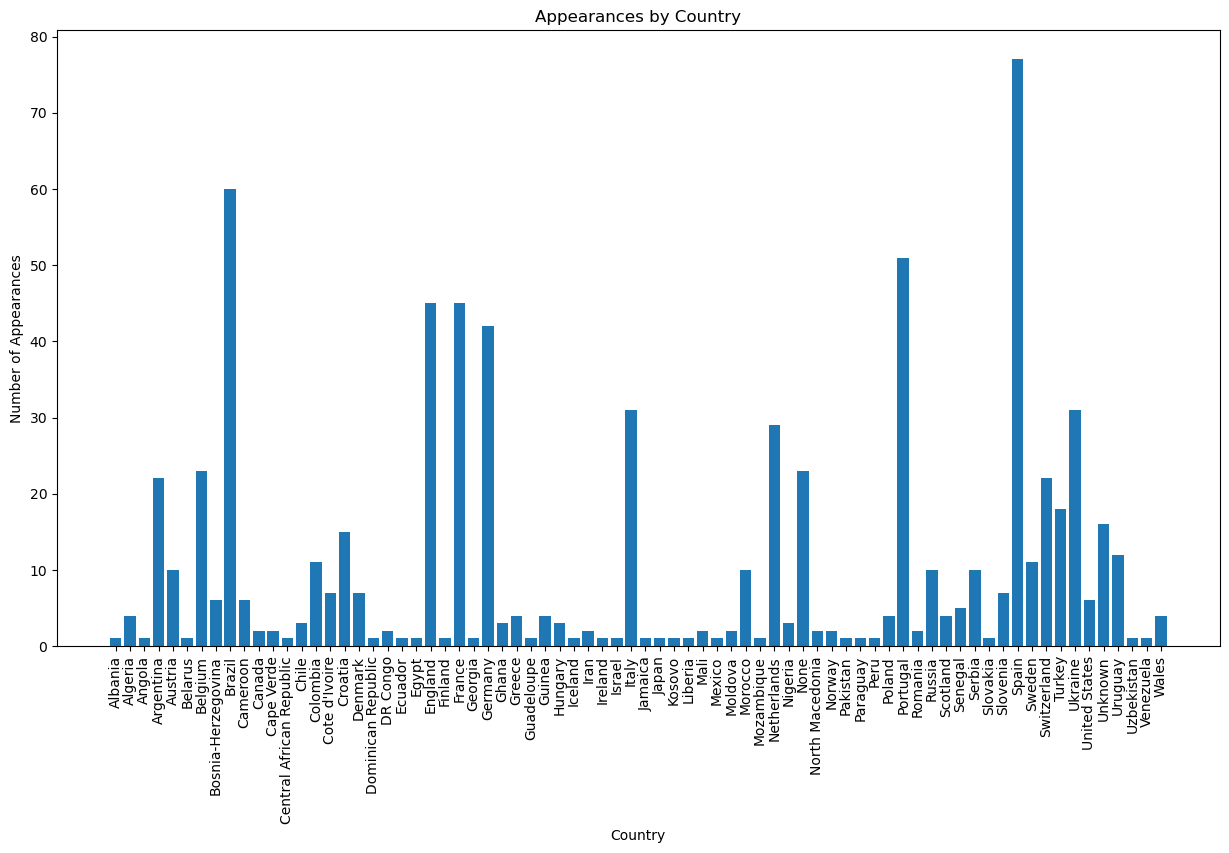

In [32]:
import mysql.connector
import matplotlib.pyplot as plt
import azure_credentials as az

# Connect to MySQL database
db = mysql.connector.connect(user=az.user,
                              password=az.azure_mysql_password,
                              host="fhtw-bdinf-wi21b080-azuredatabase-mysql.mysql.database.azure.com",
                              port=3306,
                              database="criminalsoccer",
                              ssl_ca="DigiCertGlobalRootCA.crt.pem",
                              ssl_disabled=False)

# Retrieve data from table
cursor = db.cursor()
cursor.execute("SELECT country, appearances FROM nationalities")
results = cursor.fetchall()

# Prepare data for plotting
countries = [r[0] for r in results]
appearances = [r[1] for r in results]

# Create bar chart
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(countries, appearances)

# Customize chart
ax.set_title('Appearances by Country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of Appearances')
plt.xticks(rotation=90)

# Show the chart
plt.show()
